In [1]:
import time
import pandas as pd
import umap.umap_ as umap
import umap.utils
import umap.plot
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
from pandas.plotting import table
import seaborn as sns
from tabulate import tabulate

from IPython.core.display import display, HTML

In [10]:
dataset_names = ["data_400bc", "data_200bc", "data_0bc", "data_0ad", "data_200ad"]
dataset_dict = dict()
coin_dict = dict()
for name in dataset_names:
    dataset_dict[name] = pd.read_csv(f"..\\timeperiod\\{name}.csv", sep=";")
    coin_dict[name] = dataset_dict[name]["coin"]
    del dataset_dict[name]["coin"]
    del dataset_dict[name]["Unnamed: 0"]

In [11]:
data = pd.read_csv('..\\data\\analysis_dataset_w_material.csv', sep=";")

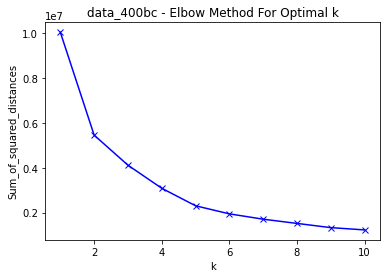

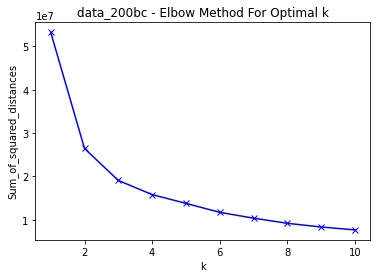

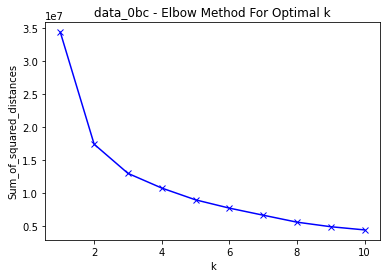

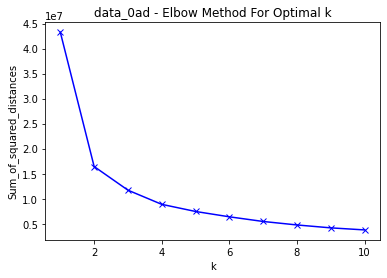

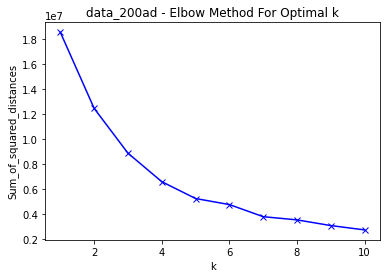

In [38]:
selected_features = ['weight', 'enddate', 'startdate', 'material_cat', 'denom_cat',
       'mint_cat']
for dataset in dataset_dict.keys():
    display(HTML(f'<h2>kMeans ellbow analysis {dataset}</h2>'))
    tmp_coins = coin_dict[dataset]
    tmp_data = data[data["coin"].isin(tmp_coins)]
    tmp_data = tmp_data[selected_features]
    dataset_dict[dataset] = tmp_data.copy()
    Sum_of_squared_distances = list()
    K = range(1,11)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(tmp_data)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title(f'{dataset} - Elbow Method For Optimal k')
    plt.show()

In [39]:
k_dict = dict()
k_dict["data_400bc"] = 5
k_dict["data_200bc"] = 3
k_dict["data_0bc"] = 2
k_dict["data_0ad"] = 2
k_dict["data_200ad"] = 4

In [41]:
for dataset in dataset_dict.keys():
    tmp_dataset = dataset_dict[dataset]
    km = KMeans(n_clusters=k_dict[dataset])
    km = km.fit(tmp_dataset)
    print(dataset)
    dataset_dict[dataset]["coin"] = [int(x) for x in coin_dict[dataset]]
    dataset_dict[dataset]["label"] = km.labels_

data_400bc
data_200bc
data_0bc
data_0ad
data_200ad


In [42]:
def prepare_data(data):
    data["weight"] = [float(str(x).replace(",",".")) for x in data["weight"]]
    data["mint"] = [x.replace("http://nomisma.org/id/", "") for x in data["mint"]]
    data["coin"] = [x.split("#coins?id=")[1] for x in data["coin"]]
    data["material"] = [x.replace("http://nomisma.org/id/", "") for x in data["material"]]
    data["denom"] = [x.replace("http://nomisma.org/id/", "") for x in data["denom"]]
    data["findspot"] = [str(x).replace("file:///C:/Users/karsten/Documents/uni/ProgrammeWorkspace/D2RServer/d2rq-0.8.1_CNT/dump_2021_03_16.rdf#", "") \
                        for x in data["findsport"]]
    data["authority"] = [x.replace(" http://nomisma.org/id/", "") for x in data["authority"]]
    categorial_vars = ["material", "denom", "mint", "collection", "weightstand_engl", "findsport", "authority", "peculiarities_engl" ]
    
    for var in categorial_vars:
        data[var] = data[var].astype('category')
        
    try:
        data['weight'] = pd.to_numeric(data['weight'],errors='coerce')
        try:
            data['maxdiam'] = pd.to_numeric(data['maxdiam'],errors='coerce')
            try: 
                data['mindiam'] = pd.to_numeric(data['mindiam'],errors='coerce')
                try:
                    data['weight'].astype(float)
                except:
                    pass
            except:
                pass
        except:
            pass
    except:
        pass
        
    return data

In [43]:
coin_data = pd.read_csv("C:\\Users\\fredi\\Desktop\\Uni\\Data Challanges\\CN\\data\\queryResults_semikolon.csv", sep=";")
coin_data = prepare_data(coin_data)
coin_data["coin"] = coin_data["coin"].astype(int)
def get_full_dataset(coins):
    return coin_data[coin_data["coin"].isin(coins)]

In [44]:
features = ['startdate', 'enddate', 'weight',\
        'mindiam', 'maxdiam', 'axis', 'material', 'mint',\
        'denom', 'collection', 'weightstand_engl', 'findsport', 'authority']
def get_subset_dataset(data, label):
    tmp_coins = get_coins(data, label)
    tmp_full_data = get_full_dataset(tmp_coins)
    tmp_full_data = tmp_full_data[features]
    return tmp_full_data
def compare_different_cluster(data):
    labels = set(data["label"].to_list())
    display(HTML(f'<h2>Category var analysis</h2>'))
    for label in labels:
        tmp_full_data = get_subset_dataset(data, label)
        display(HTML(f'<h4>Label: {label} </h4>'))
        print(tabulate(np.round(tmp_full_data.describe(include="category")), headers='keys', tablefmt='psql'))
    display(HTML(f'<h2>Mint analysis</h2>'))
    mint_df = pd.DataFrame()
    for label in labels:
        tmp_full_data = get_subset_dataset(data, label)
        mint_agg = tmp_full_data.groupby("mint")["enddate"].count().reset_index()
        mint_agg = mint_agg.rename(columns={"enddate": "count"})
        mint_agg = mint_agg.sort_values("count", ascending=False)
        mint_agg = mint_agg.head(10)
        mint_agg = mint_agg.reset_index()
        mint_df[f"{label} mint"] = mint_agg["mint"]
        mint_df[f"{label} freq"] = mint_agg["count"]
    display(mint_df)
    display(HTML(f'<h2>Numeric var analysis</h2>'))
    for label in labels:
        tmp_full_data = get_subset_dataset(data, label)
        display(HTML(f'<h4>Label: {label} </h4>'))
        print(tabulate(np.round(tmp_full_data.describe(include="number")), headers='keys', tablefmt='psql'))
    display(HTML(f'<h2>Category (CatI) analysis</h2>'))
    category_df = pd.DataFrame()
    for label in labels:
        tmp_coins = get_coins(data, label)
        tmp_cat = get_entity_top20_catI(tmp_coins)
        category_df[f"{label}"] = tmp_cat["Cat_I"]
        category_df[f"{label} freq"] = tmp_cat["count"]
    display(category_df)
    display(HTML(f'<h2>Entity analysis</h2>'))
    entity_df = pd.DataFrame()
    for label in labels:
        tmp_coins = get_coins(data, label)
        tmp_entity = get_top20_entitys(tmp_coins)
        #print(type(tmp_entity))
        entity_names = tmp_entity.index
        entity_df[f"{label}"] = [x.replace("entity_", "") for x in entity_names]
        entity_df[f"{label} freq"] = tmp_entity.values
    print(entity_df)

In [45]:
entity_dummys = pd.read_csv("..\\2021_06_01_DC_NLP_CNT\\design_dummys.csv", sep=";")
del entity_dummys["Unnamed: 0"]
def get_entitys(coins):
    return entity_dummys[entity_dummys["id_coin"].isin(coins)]

In [46]:
def get_top20_entitys(coins):
    entitys = get_entitys(coins)
    del entitys["id_coin"]
    #print(entitys.sum().sort_values(ascending=False).head(20))
    return entitys.sum().sort_values(ascending=False).head(20)

In [47]:
entity_cat_data = pd.read_csv("..\\2021_06_01_DC_NLP_CNT\\design_data2_cat_v2.csv", sep=";")
entity_cat_data.columns
entity_cat_data = entity_cat_data[entity_cat_data["Label_Entity"]!="VERBS"]
def get_entity_top20_catI(coins):
    tmp_data = entity_cat_data[entity_cat_data["id_coin"].isin(coins)]
    catI = tmp_data.groupby("Cat_I")["id_coin"].count().reset_index()
    catI = catI.rename(columns={"id_coin": "count"})
    catI = catI.sort_values("count", ascending=False)
    return catI.head(20).reset_index()

In [50]:
def get_coins(data, label):
    tmp_data = data[data["label"]==label]
    tmp_coins = tmp_data["coin"].to_list()
    return [int(x) for x in tmp_coins]
    

In [51]:
pd.set_option('display.expand_frame_repr', False)

for dataset in dataset_dict.keys():
    display(HTML(f'<h1>Analysis - {dataset}</h1>'))
    tmp_dataset = dataset_dict[dataset]
    print(f"Dataset shape: {tmp_dataset.shape}")
    compare_different_cluster(tmp_dataset)

Dataset shape: (2320, 8)


+--------+------------+--------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint   | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+--------+---------+--------------+--------------------+-------------+-------------|
| count  | 687        | 687    | 687     | 687          | 687                | 687         | 687         |
| unique | 3          | 11     | 16      | 625          | 8                  | 4           | 1           |
| top    | ar         |        | stater  |              | reduced chian      |             |             |
| freq   | 662        | 210    | 120     | 63           | 204                | 684         | 687         |
+--------+------------+--------+---------+--------------+--------------------+-------------+-------------+


+--------+------------+--------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint   | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+--------+---------+--------------+--------------------+-------------+-------------|
| count  | 549        | 549    | 549     | 549          | 549                | 549         | 549         |
| unique | 5          | 12     | 16      | 419          | 6                  | 1           | 3           |
| top    | ar         | aenus  | stater  |              |                    |             |             |
| freq   | 385        | 218    | 194     | 131          | 238                | 549         | 518         |
+--------+------------+--------+---------+--------------+--------------------+-------------+-------------+


+--------+------------+---------+--------------+--------------+--------------------+-------------+-------------+
|        | material   | mint    | denom        | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+---------+--------------+--------------+--------------------+-------------+-------------|
| count  | 526        | 526     | 526          | 526          | 526                | 526         | 526         |
| unique | 3          | 9       | 16           | 310          | 7                  | 5           | 1           |
| top    | el         | cyzicus | sixth-stater |              |                    |             |             |
| freq   | 429        | 460     | 218          | 217          | 484                | 516         | 526         |
+--------+------------+---------+--------------+--------------+--------------------+-------------+-------------+


+--------+------------+----------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint     | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+----------+---------+--------------+--------------------+-------------+-------------|
| count  | 235        | 235      | 235     | 235          | 235                | 235         | 235         |
| unique | 1          | 7        | 13      | 235          | 8                  | 2           | 1           |
| top    | ar         | maroneia | drachma |              | Thraco-Macedonian  |             |             |
| freq   | 235        | 84       | 45      | 1            | 115                | 234         | 235         |
+--------+------------+----------+---------+--------------+--------------------+-------------+-------------+


+--------+------------+----------+-------------+--------------+--------------------+-------------+-------------+
|        | material   | mint     | denom       | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+----------+-------------+--------------+--------------------+-------------+-------------|
| count  | 323        | 323      | 323         | 323          | 323                | 323         | 323         |
| unique | 2          | 15       | 16          | 323          | 5                  | 1           | 2           |
| top    | ar         | maroneia | tetradrachm | b1118        | Thraco-Macedonian  |             |             |
| freq   | 315        | 167      | 84          | 1            | 171                | 323         | 322         |
+--------+------------+----------+-------------+--------------+--------------------+-------------+-------------+


,0 mint,0 freq,1 mint,1 freq,2 mint,2 freq,3 mint,3 freq,4 mint,4 freq
0,,210,aenus,218,cyzicus,460,maroneia,84,maroneia,167
1,abdera_thrace,126,cyzicus,147,dicaea_thrace,19,thasos,56,thasos,60
2,aenus,107,abdera_thrace,86,abdera_thrace,15,selymbria,55,selymbria,21
3,dicaea_thrace,78,,48,,13,tenedos,26,neandria,17
4,cebren,75,apollonia_pontica,14,cardia,10,samothrace,9,gargara,12
5,abydus,47,cebren,10,apollonia_pontica,3,mesembria,3,parium,12
6,cyzicus,12,dicaea_thrace,8,maroneia,2,lamponeia,2,lamponeia,8
7,dardanus,12,atarneus,6,chersonesus_thrace,2,,0,trierus,8
8,assus,10,assus,6,cebren,2,nicopolis_ad_istrum,0,teuthrania,8
9,apollonia_pontica,7,abydus,3,thymbra,0,nicopolis_ad_nestum,0,proconnesus,3


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |         687 |       687 |      687 |       247 |       331 |    108 |
| mean  |        -488 |      -460 |       10 |        17 |        19 |      6 |
| std   |          17 |        12 |       11 |         8 |         8 |      3 |
| min   |        -530 |      -500 |        0 |         5 |         6 |      1 |
| 25%   |        -500 |      -466 |        1 |        11 |        12 |      3 |
| 50%   |        -490 |      -460 |        5 |        16 |        18 |      6 |
| 75%   |        -475 |      -450 |       16 |        24 |        24 |      9 |
| max   |        -455 |      -440 |       41 |        37 |        37 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |         549 |       549 |      549 |        95 |       249 |    146 |
| mean  |        -444 |      -416 |        9 |        16 |        16 |      7 |
| std   |          25 |        11 |        7 |         7 |         6 |      4 |
| min   |        -500 |      -450 |        0 |         8 |         7 |      1 |
| 25%   |        -460 |      -425 |        1 |        11 |        11 |      5 |
| 50%   |        -450 |      -410 |       13 |        13 |        13 |      6 |
| 75%   |        -423 |      -409 |       16 |        22 |        22 |     11 |
| max   |        -400 |      -400 |       18 |        28 |        28 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |         526 |       526 |      526 |        37 |       189 |     23 |
| mean  |        -549 |      -481 |        7 |        17 |        14 |      7 |
| std   |          16 |        18 |        6 |         7 |         5 |      4 |
| min   |        -600 |      -550 |        0 |         6 |         6 |      1 |
| 25%   |        -550 |      -475 |        2 |        12 |        10 |      3 |
| 50%   |        -550 |      -475 |        3 |        19 |        11 |      6 |
| 75%   |        -550 |      -475 |       16 |        21 |        19 |     10 |
| max   |        -510 |      -450 |       23 |        39 |        39 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |         235 |       235 |      235 |       118 |       174 |     32 |
| mean  |        -497 |      -468 |        3 |        14 |        15 |      7 |
| std   |          15 |        14 |        3 |         4 |         5 |      4 |
| min   |        -525 |      -505 |        0 |         6 |         6 |      1 |
| 25%   |        -505 |      -478 |        1 |        10 |        11 |      2 |
| 50%   |        -492 |      -470 |        2 |        14 |        15 |      8 |
| 75%   |        -490 |      -450 |        4 |        16 |        19 |     12 |
| max   |        -463 |      -448 |       10 |        24 |        27 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |         323 |       323 |      323 |       134 |       263 |     95 |
| mean  |        -437 |      -409 |        6 |        18 |        17 |      6 |
| std   |          20 |        12 |        5 |         5 |         6 |      3 |
| min   |        -500 |      -440 |        0 |         7 |         6 |      1 |
| 25%   |        -450 |      -411 |        1 |        15 |        10 |      4 |
| 50%   |        -430 |      -400 |        4 |        18 |        17 |      6 |
| 75%   |        -425 |      -400 |       13 |        23 |        22 |      9 |
| max   |        -400 |      -400 |       14 |        28 |        30 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


,0,0 freq,1,1 freq,2,2 freq,3,3 freq,4,4 freq
0,Bird,261,BodyParts,295,Fish,423.0,Bird,55.0,Mamal,84.0
1,BodyParts,226,Male,280,BodyParts,167.0,Flower,19.0,BodyParts,52.0
2,Male,193,Mamal,226,Mamal,83.0,Clothing,16.0,Male,24.0
3,Mamal,179,Fish,151,Clothing,50.0,Mamal,8.0,Bird,21.0
4,Architecture,38,Bird,124,Bird,49.0,BodyParts,5.0,Clothing,14.0
5,Tools,35,Clothing,52,Female,25.0,Architecture,2.0,Female,5.0
6,Clothing,19,Reptile,31,Architecture,17.0,Male,2.0,Architecture,1.0
7,Fish,12,Arms,28,Arms,16.0,Arms,1.0,Arms,1.0
8,Tree,7,Female,24,Male,10.0,Tools,1.0,Fish,1.0
9,NauticalObject,7,Architecture,21,Shellfish,8.0,Vessel-Jar,1.0,NaN,NaN


              0  0 freq             1  1 freq             2  2 freq            3  3 freq             4  4 freq
0          Kopf     226          Kopf     291     Thunfisch     423      Pferdes      78      Weinrebe      87
1        Hermes     193       Petasos     219          Kopf     164         Hahn      55         Pferd      84
2       Petasos     190        Hermes     219         Greif      43   Sternblume      19       Pferdes      75
3         Greif     136    Ziegenbock     213         Löwen      38        Silen      12          Kopf      52
4    Ziegenbock      85     Thunfisch     151          Hund      35       Gewand      11  Lorbeerkranz      24
5          Hahn      78         Greif      84          Helm      31       Sphinx       8       Apollon      24
6     Löwenfell      72      Schlange      31          Löwe      26         Helm       5          Hahn      21
7      Herakles      72         Adler      30      Herakles      26         Kopf       5        Widder      17
8

Dataset shape: (8382, 8)


+--------+------------+--------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint   | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+--------+---------+--------------+--------------------+-------------+-------------|
| count  | 3981       | 3981   | 3981    | 3981         | 3981               | 3981        | 3981        |
| unique | 6          | 70     | 20      | 3905         | 8                  | 9           | 12          |
| top    | ae         | abydus |         |              |                    |             |             |
| freq   | 2350       | 384    | 2311    | 77           | 2789               | 3970        | 3804        |
+--------+------------+--------+---------+--------------+--------------------+-------------+-------------+


+--------+------------+------------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint       | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+------------+---------+--------------+--------------------+-------------+-------------|
| count  | 1710       | 1710       | 1710    | 1710         | 1710               | 1710        | 1710        |
| unique | 4          | 37         | 18      | 1654         | 7                  | 10          | 12          |
| top    | ae         | lysimachia |         |              |                    |             |             |
| freq   | 1322       | 388        | 1238    | 57           | 1580               | 1697        | 1477        |
+--------+------------+------------+---------+--------------+--------------------+-------------+-------------+


+--------+------------+-----------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint      | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+-----------+---------+--------------+--------------------+-------------+-------------|
| count  | 2691       | 2691      | 2691    | 2691         | 2691               | 2691        | 2691        |
| unique | 5          | 28        | 25      | 2560         | 13                 | 12          | 7           |
| top    | ar         | byzantium | drachma |              |                    |             |             |
| freq   | 1621       | 628       | 667     | 132          | 1300               | 2529        | 2628        |
+--------+------------+-----------+---------+--------------+--------------------+-------------+-------------+


,0 mint,0 freq,1 mint,1 freq,2 mint,2 freq
0,abydus,384,lysimachia,388,byzantium,628
1,abdera_thrace,359,byzantium,340,cherronesus,455
2,cardia,317,pergamum,242,maroneia,358
3,chersonesus_thrace,316,aenus,113,abdera_thrace,240
4,maroneia,267,,73,aenus,171
5,cebren,150,abydus,60,lampsacus,128
6,,130,pitane,47,istrus,120
7,gargara,111,dardanus,45,cyzicus,97
8,dardanus,111,bisanthe,42,apollonia_pontica,68
9,birytis,96,sestus,40,thasos,68


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |        3981 |      3981 |     3981 |       879 |      2257 |   1901 |
| mean  |        -352 |      -313 |        4 |        16 |        15 |      8 |
| std   |          19 |        19 |        3 |         4 |         4 |      4 |
| min   |        -410 |      -352 |        0 |         7 |         6 |      1 |
| 25%   |        -360 |      -330 |        2 |        13 |        12 |      5 |
| 50%   |        -350 |      -310 |        2 |        15 |        14 |      8 |
| 75%   |        -350 |      -300 |        4 |        19 |        18 |     12 |
| max   |        -294 |      -250 |       21 |        31 |        32 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |        1710 |      1710 |     1710 |       551 |      1145 |    973 |
| mean  |        -283 |      -228 |        7 |        21 |        20 |      9 |
| std   |          28 |        29 |        5 |         5 |         6 |      4 |
| min   |        -355 |      -287 |        0 |         9 |         7 |      1 |
| 25%   |        -300 |      -250 |        3 |        18 |        17 |      6 |
| 50%   |        -286 |      -219 |        6 |        21 |        20 |     12 |
| 75%   |        -262 |      -200 |        9 |        23 |        23 |     12 |
| max   |        -200 |      -200 |       18 |        35 |        35 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |        2691 |      2691 |     2691 |      1146 |      1925 |    950 |
| mean  |        -403 |      -362 |        4 |        15 |        15 |      8 |
| std   |          28 |        24 |        5 |         4 |         4 |      4 |
| min   |        -500 |      -399 |        0 |         5 |         5 |      1 |
| 25%   |        -411 |      -386 |        1 |        12 |        11 |      5 |
| 50%   |        -400 |      -365 |        3 |        15 |        14 |      9 |
| 75%   |        -385 |      -347 |        5 |        17 |        17 |     12 |
| max   |        -359 |      -300 |       17 |        28 |        28 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


,0,0 freq,1,1 freq,2,2 freq
0,BodyParts,2926,BodyParts,1784,BodyParts,781
1,Male,1360,Female,1135,Male,329
2,Bird,907,Clothing,964,Mamal,306
3,Clothing,853,Arms,695,Bird,271
4,Female,672,Male,560,Clothing,198
5,Mamal,641,Ornaments,204,Female,115
6,Ornaments,530,Bird,181,Ornaments,112
7,Arms,451,Stone,105,Fish,92
8,Astrological,111,Mamal,90,Arms,81
9,Vessel-Jar,98,Architecture,84,Architecture,49


               0  0 freq                     1  1 freq             2  2 freq
0           Kopf    2847                  Kopf    1780          Kopf     773
1   Lorbeerkranz    1428                Athena     462       Delphin     682
2        Apollon    1061                  Nike     346          Rind     509
3           Helm     443          Lorbeerkranz     336       Pferdes     373
4          Löwen     421                  Helm     256    Weintraube     260
5          Pferd     412                Schild     233         Greif     244
6          Greif     394                 Speer     224        Ranken     231
7         Athena     337               Apollon     214       Petasos     204
8          Adler     324            Ährenkranz     213        Hermes     201
9        Pferdes     250              Herakles     204    Ziegenbock     185
10       Ohrring     209             Löwenfell     203  Lorbeerkranz     127
11      Weinrebe     191               Demeter     192     Dreizacks     114

Dataset shape: (3738, 8)


+--------+------------+----------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint     | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+----------+---------+--------------+--------------------+-------------+-------------|
| count  | 2229       | 2229     | 2229    | 2229         | 2229               | 2229        | 2229        |
| unique | 5          | 40       | 10      | 2145         | 5                  | 4           | 8           |
| top    | ae         | pergamum |         |              |                    |             |             |
| freq   | 1322       | 701      | 1310    | 85           | 1850               | 2220        | 2152        |
+--------+------------+----------+---------+--------------+--------------------+-------------+-------------+


+--------+------------+----------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint     | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+----------+---------+--------------+--------------------+-------------+-------------|
| count  | 1509       | 1509     | 1509    | 1509         | 1509               | 1509        | 1509        |
| unique | 5          | 32       | 13      | 1433         | 5                  | 8           | 8           |
| top    | ae         | pergamum |         |              |                    |             |             |
| freq   | 951        | 360      | 883     | 77           | 1492               | 1411        | 1296        |
+--------+------------+----------+---------+--------------+--------------------+-------------+-------------+


,0 mint,0 freq,1 mint,1 freq
0,pergamum,701,pergamum,360
1,maroneia,613,maroneia,236
2,abydus,136,mesembria,173
3,,97,adramyteum,133
4,thasos,82,thasos,103
5,mesembria,64,perinthus,66
6,samothrace,63,lampsacus,57
7,byzantium,58,callatis,51
8,sestus,52,imbros,46
9,aenus,51,abdera_thrace,40


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |        2229 |      2229 |     2229 |       538 |      1562 |   1060 |
| mean  |        -123 |       -49 |        9 |        23 |        23 |     10 |
| std   |          46 |        35 |        5 |         7 |         7 |      4 |
| min   |        -200 |      -136 |        1 |        10 |         9 |      1 |
| 25%   |        -150 |       -80 |        4 |        17 |        18 |     11 |
| 50%   |        -125 |       -48 |        8 |        22 |        22 |     12 |
| 75%   |        -100 |       -10 |       15 |        30 |        30 |     12 |
| max   |           0 |         0 |       35 |        39 |        39 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |        1509 |      1509 |     1509 |       408 |       990 |    634 |
| mean  |        -227 |      -138 |        8 |        22 |        21 |     10 |
| std   |          43 |        38 |        6 |         7 |         7 |      4 |
| min   |        -350 |      -198 |        0 |         7 |         8 |      1 |
| 25%   |        -276 |      -167 |        3 |        16 |        15 |      9 |
| 50%   |        -220 |      -133 |        6 |        20 |        19 |     12 |
| 75%   |        -196 |      -100 |       16 |        30 |        28 |     12 |
| max   |        -146 |       -30 |       20 |        37 |        41 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


,0,0 freq,1,1 freq
0,Clothing,1651,BodyParts,1202.0
1,BodyParts,1591,Clothing,935.0
2,Female,733,Female,541.0
3,Architecture,464,Arms,485.0
4,Vessel-Jar,364,Male,380.0
5,Reptile,341,Mamal,244.0
6,Male,331,Bird,206.0
7,Bird,315,Vessel-Jar,181.0
8,Arms,177,Bar,139.0
9,Ornaments,130,Reptile,120.0


               0  0 freq             1  1 freq
0           Kopf    1583          Kopf    1201
1       Dionysos    1170        Athena     433
2      Efeukranz     850     Efeukranz     322
3     Weintraube     563  Lorbeerkranz     290
4        Speeren     531        Schild     274
5   Lorbeerkranz     490         Pferd     222
6         Athena     404      Weinrebe     214
7           Helm     363          Zeus     213
8         Köcher     356     Löwenfell     212
9          Bogen     346      Herakles     212
10      Schlange     341       Trauben     210
11     Schlangen     271         Kranz     206
12         Cista     271          Helm     169
13     Asklepios     203         Adler     140
14         Adler     189        Zepter     139
15     Brustbild     185      Dionysos     130
16        Gewand     184      Schlange     120
17     Palmzweig     173         Keule     119
18        Diadem     146       Apollon      81
19       Artemis     141        Köcher      79


Dataset shape: (5344, 8)


+--------+------------+---------------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint          | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+---------------+---------+--------------+--------------------+-------------+-------------|
| count  | 4216       | 4216          | 4216    | 4216         | 4216               | 4216        | 4216        |
| unique | 4          | 53            | 14      | 4114         | 1                  | 25          | 3           |
| top    | ae         | philippopolis |         |              |                    |             |             |
| freq   | 4162       | 1705          | 1358    | 103          | 4216               | 4161        | 4209        |
+--------+------------+---------------+---------+--------------+--------------------+-------------+-------------+


+--------+------------+---------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint    | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+---------+---------+--------------+--------------------+-------------+-------------|
| count  | 1128       | 1128    | 1128    | 1128         | 1128               | 1128        | 1128        |
| unique | 3          | 27      | 16      | 1115         | 2                  | 8           | 5           |
| top    | ae         | cyzicus |         |              |                    |             |             |
| freq   | 1086       | 236     | 835     | 14           | 1111               | 1112        | 949         |
+--------+------------+---------+---------+--------------+--------------------+-------------+-------------+


,0 mint,0 freq,1 mint,1 freq
0,philippopolis,1705,cyzicus,236
1,byzantium,394,perinthus,205
2,perinthus,383,,197
3,pergamum,250,pergamum,79
4,augusta_trajana,203,philippopolis,75
5,hadrianopolis_thrace,175,imbros,49
6,topirus,170,ilium,31
7,germe,95,abydus,31
8,pautalia,82,byzantium,30
9,bizya,71,sestus,26


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |        4216 |      4216 |     4216 |      1419 |      2250 |   1790 |
| mean  |         149 |       170 |        8 |        23 |        23 |      7 |
| std   |          29 |        24 |        6 |         6 |         6 |      3 |
| min   |           1 |        98 |        1 |        11 |        12 |      1 |
| 25%   |         138 |       161 |        4 |        18 |        19 |      6 |
| 50%   |         147 |       175 |        5 |        23 |        22 |      6 |
| 75%   |         177 |       192 |       10 |        26 |        26 |      8 |
| max   |         200 |       200 |       64 |        47 |        48 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |        1128 |      1128 |     1128 |       496 |       802 |    702 |
| mean  |          22 |        53 |        7 |        21 |        21 |      8 |
| std   |          50 |        41 |        5 |         6 |         6 |      4 |
| min   |        -168 |         1 |        1 |         9 |         9 |      1 |
| 25%   |         -27 |        14 |        3 |        16 |        16 |      6 |
| 50%   |          37 |        50 |        5 |        20 |        20 |      7 |
| 75%   |          63 |        81 |        9 |        25 |        24 |     12 |
| max   |          98 |       200 |       28 |        36 |        36 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


,0,0 freq,1,1 freq
0,Male,3415,BodyParts,973
1,Clothing,2615,Male,957
2,BodyParts,2040,Clothing,410
3,Female,1393,Female,391
4,Vessel-Jar,1006,Arms,161
5,Arms,725,Vessel-Jar,145
6,Architecture,536,Architecture,89
7,Tools,414,Tools,77
8,Bar,237,Ornaments,55
9,Ornaments,224,MusicalInstruments,51


                 0  0 freq             1  1 freq
0        Brustbild    2068          Kopf     972
1             Kopf    2030  Lorbeerkranz     413
2     Lorbeerkranz    1876      Augustus     329
3     Paludamentum    1037     Brustbild     190
4           Panzer     993      Domitian     169
5           Gewand     862  Rhoimetalkes     132
6   Antoninus Pius     793        Gewand     126
7           Patera     754        Diadem     110
8         Commodus     680        Patera      97
9         Füllhorn     436          Nero      93
10      Marc Aurel     353         Köpfe      89
11            Helm     329   Eichenkranz      77
12        Dionysos     324       Apollon      76
13         Thyrsos     270      Dionysos      71
14         Apollon     270         Ähren      70
15          Trajan     260        Fackel      64
16           Ähren     257    Pythodoris      60
17        Homonoia     256          Helm      55
18       Kantharos     251        Athena      46
19          Fackel  

Dataset shape: (8046, 8)


+--------+------------+---------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint    | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+---------+---------+--------------+--------------------+-------------+-------------|
| count  | 2023       | 2023    | 2023    | 2023         | 2023               | 2023        | 2023        |
| unique | 3          | 36      | 10      | 1959         | 3                  | 7           | 1           |
| top    | ae         | deultum | 4-unit  |              |                    |             |             |
| freq   | 2003       | 439     | 930     | 65           | 2021               | 2000        | 2023        |
+--------+------------+---------+---------+--------------+--------------------+-------------+-------------+


+--------+------------+-----------------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint            | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+-----------------+---------+--------------+--------------------+-------------+-------------|
| count  | 2006       | 2006            | 2006    | 2006         | 2006               | 2006        | 2006        |
| unique | 2          | 23              | 13      | 1972         | 1                  | 9           | 4           |
| top    | ae         | augusta_trajana |         |              |                    |             |             |
| freq   | 2005       | 570             | 595     | 35           | 2006               | 1995        | 1882        |
+--------+------------+-----------------+---------+--------------+--------------------+-------------+-------------+


+--------+------------+---------------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint          | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+---------------+---------+--------------+--------------------+-------------+-------------|
| count  | 3899       | 3899          | 3899    | 3899         | 3899               | 3899        | 3899        |
| unique | 4          | 26            | 9       | 3456         | 1                  | 39          | 4           |
| top    | ae         | philippopolis |         |              |                    |             |             |
| freq   | 3780       | 1212          | 1462    | 444          | 3899               | 3817        | 3837        |
+--------+------------+---------------+---------+--------------+--------------------+-------------+-------------+


+--------+------------+-----------+---------+--------------+--------------------+-------------+-------------+
|        | material   | mint      | denom   | collection   | weightstand_engl   | findsport   | authority   |
|--------+------------+-----------+---------+--------------+--------------------+-------------+-------------|
| count  | 118        | 118       | 118     | 118          | 118                | 118         | 118         |
| unique | 2          | 10        | 5       | 100          | 4                  | 1           | 1           |
| top    | ae         | byzantium |         |              |                    |             |             |
| freq   | 114        | 60        | 58      | 19           | 114                | 118         | 118         |
+--------+------------+-----------+---------+--------------+--------------------+-------------+-------------+


,0 mint,0 freq,1 mint,1 freq,2 mint,2 freq,3 mint,3 freq
0,deultum,439,augusta_trajana,570,philippopolis,1212,byzantium,60
1,hadrianopolis_thrace,284,byzantium,440,perinthus,645,callatis,32
2,perinthus,209,hadrianopolis_thrace,256,marcianopolis,411,hephaestia,12
3,mesembria,135,alexandreia_troas,149,serdica,237,abydus,6
4,marcianopolis,131,adramyteum,88,nicopolis_ad_nestum,237,alexandreia_troas,2
5,bizya,115,anchialus,87,trajanopolis_thrace,171,maroneia,2
6,anchialus,94,deultum,84,nicopolis_ad_istrum,169,tenedos,1
7,coela,87,abydus,79,pergamum,168,chersonesus_thrace,1
8,germe,85,bizya,48,pautalia,159,lemnos,1
9,byzantium,83,coela,37,topirus,141,serdica,1


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |        2023 |      2023 |     2023 |       930 |      1576 |   1080 |
| mean  |         240 |       246 |       10 |        25 |        26 |      6 |
| std   |           8 |         8 |        6 |         4 |         5 |      3 |
| min   |         200 |       233 |        1 |        12 |        12 |      1 |
| 25%   |         238 |       244 |        7 |        23 |        23 |      6 |
| 50%   |         238 |       244 |        9 |        25 |        26 |      6 |
| 75%   |         244 |       249 |       12 |        26 |        28 |      7 |
| max   |         320 |       330 |       60 |        42 |        49 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |        2006 |      2006 |     2006 |      1156 |      1649 |    977 |
| mean  |         206 |       217 |       11 |        26 |        26 |      7 |
| std   |          12 |         9 |        7 |         5 |         5 |      3 |
| min   |         160 |       202 |        1 |        12 |        12 |      1 |
| 25%   |         197 |       211 |        6 |        23 |        23 |      6 |
| 50%   |         202 |       217 |       11 |        27 |        27 |      6 |
| 75%   |         212 |       218 |       15 |        29 |        29 |      8 |
| max   |         236 |       238 |       43 |        41 |        44 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |        3899 |      3899 |     3899 |      1116 |      1883 |   1745 |
| mean  |         206 |       217 |       13 |        28 |        28 |      6 |
| std   |          11 |         6 |        9 |         7 |         7 |      4 |
| min   |         150 |       201 |        1 |        14 |        14 |      1 |
| 25%   |         196 |       211 |        6 |        23 |        23 |      2 |
| 50%   |         209 |       217 |       12 |        28 |        28 |      6 |
| 75%   |         217 |       218 |       16 |        31 |        30 |      8 |
| max   |         249 |       251 |       93 |        45 |        60 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


+-------+-------------+-----------+----------+-----------+-----------+--------+
|       |   startdate |   enddate |   weight |   mindiam |   maxdiam |   axis |
|-------+-------------+-----------+----------+-----------+-----------+--------|
| count |         118 |       118 |      118 |        61 |        78 |     45 |
| mean  |          54 |       294 |        5 |        21 |        21 |      6 |
| std   |         117 |        30 |        2 |         2 |         2 |      4 |
| min   |        -480 |       220 |        1 |        15 |        15 |      1 |
| 25%   |         100 |       299 |        4 |        20 |        20 |      2 |
| 50%   |         100 |       300 |        5 |        21 |        21 |      6 |
| 75%   |         100 |       300 |        6 |        22 |        22 |      8 |
| max   |         101 |       425 |       16 |        23 |        29 |     12 |
+-------+-------------+-----------+----------+-----------+-----------+--------+


,0,0 freq,1,1 freq,2,2 freq,3,3 freq
0,Clothing,2454,Male,1706,Male,3156,Clothing,90.0
1,Male,1878,Clothing,1564,Clothing,2030,BodyParts,58.0
2,Female,1119,BodyParts,789,BodyParts,1529,Bush,37.0
3,BodyParts,728,Female,589,Vessel-Jar,1166,Female,23.0
4,Vessel-Jar,693,Arms,543,Female,1058,Arms,22.0
5,Arms,462,Vessel-Jar,506,Arms,821,Leaves,22.0
6,Architecture,355,Architecture,424,Architecture,816,Male,9.0
7,Tools,228,Mamal,215,Ornaments,346,Architecture,8.0
8,Bar,194,Tools,195,Tools,340,Mamal,8.0
9,Mamal,163,Bar,150,Bar,309,Ornaments,6.0


                  0  0 freq                  1  1 freq                  2  2 freq           3  3 freq
0         Brustbild    1372          Brustbild    1269       Lorbeerkranz    2536  Weintraube      60
1      Paludamentum    1228       Lorbeerkranz    1157          Brustbild    1869        Kopf      58
2            Panzer    1160       Paludamentum     852               Kopf    1470    Dionysos      57
3      Lorbeerkranz    1067             Panzer     836             Panzer    1231   Brustbild      42
4           Gordian     740               Kopf     776          Caracalla    1157   Efeukranz      41
5              Kopf     722          Caracalla     633       Paludamentum    1124       Ranke      37
6            Gewand     603             Gewand     339             Patera     675      Gewand      24
7            Patera     384               Geta     277  Septimius Severus     660       Blatt      22
8            Diadem     355             Patera     272           Elagabal     572 